# Deep reinforcement learning

Some introductory remarks:

1. This is not an assignment, this is a demo to make learning about the deep reinforcement learning easier. Run it. Observe its behaviour. Change it. Run it again. And change it again. And again.
2. While developing this demo I found some on-line resources helpful (but neither covers exactly the scope of this demo):
    * https://www.analyticsvidhya.com/blog/2019/04/introduction-deep-q-learning-python/
    * https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
3. Some things are written in a suboptimal way to make the code simpler.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F

import collections

import numpy as np
import matplotlib.pylab as plt
from IPython import display
%matplotlib inline

## Preparing an environment

Reinforcement learning requires an agent and an environment for the agent. We will use one of the environments provided by the *OpenAI Gym* called *CartPole*.
The following description is copied from https://gym.openai.com/envs/CartPole-v1/

> A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

**Note:** There are multiple environment available. Feel free to experiment with them, but remember that this may require substantial changes in the hyperparameters and/or in the agent's code.

In [2]:
import gym
env = gym.make('CartPole-v1')

Each environment in the OpenAI Gym has some action space (here 2 different actions are possible)

In [3]:
env.action_space

Discrete(2)

And an observation space (here consisting of 4 continous variables)

In [4]:
env.observation_space

Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)

Lets see the environment in action: the code below performs random actions, which are visualised (`env.render()`) for your enjoyment. Observe that a only a handful of actions can be executed this way before the episode ends.

In [10]:
env.reset()
for t in range(100):
    env.render()    
    action = env.action_space.sample()
    newstate, reward, done, info = env.step(action)
    if done:
        print("Finished after", t, "steps")
        break

Finished after 24 steps


## Preparing an agent

We create two identical neural networks, one called `target` and the other called `policy`. Their purpose is to approximate the function $Q(s,a)$, but in a somewhat special way: an input of a model is the current state `s` and the outputs are the values of $Q(s, a)$ for each possible action.

The explanation why there are two models is a bit complicated: recall that in the Q-learning algorithm the agent updates $Q(s,a)$ to the value of $r+\gamma \max_{a'} Q(s', a')$ (where $r$ stands for a reward received after transitioning from $s$ to $s'$ using the action $a$). Now, should we use the same network to approximate both the current value $Q(s,a)$ and the target value $r+\gamma \max_{a'} Q(s', a')$ it would mean that changing the parameters of the network changes both the current value $Q(s,a)$ and the target value, which is perhaps rather unfortunate. Instead, we use an off-line copy of the network to compute the target value and perdiocially (and rather rarely) update it by copying the parameters of the on-line network to the off-line network. 

In the code below the variable `policy` represents the on-line model which is used to compute $Q(s,a)$ and `target` represents the off-line model used to compute $Q(s',a')$ in the target value. Both models have an identical structure defined by the function `create_model` and the call to the function `target.load_state_dict` ensures that both are initialized with exactly the same values of parameters.

**Note**: Consider modifying the used model, e.g., remove `BatchNorm1d`, add/remove a layer, make a layer wider/narrower, change nonlinearity. These changes should not require substantial changes in the other parts of the code. You can also try to remove the second model (`target`) alltogether (`target=policy` should do the trick, after all variables in Python store references, not the objects themselves).

In [11]:
n_actions = env.action_space.n
n_observations = sum(env.observation_space.shape)

def create_model():
    return nn.Sequential(        
        nn.BatchNorm1d(n_observations),
        nn.Sequential(
            nn.Linear(n_observations, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU()
        ),
        nn.Sequential(
            nn.Linear(32, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU()
        ),
        nn.Linear(32, n_actions)
    )

target = create_model()
policy = create_model()
target.load_state_dict(policy.state_dict())

<All keys matched successfully>

For the loss function we use the smooth L1 loss (https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html) and to optimize the parameters (of the `policy` network only!) we use the Adam optimizer.

**Note**: Both are some arbitrary choices and you're free to experiment with them.

In [12]:
lossfn = nn.SmoothL1Loss()
opt = optim.Adam(policy.parameters())

## Training the agent

The following function `training_step` updates the `policy` network using the given `experience`, which is an iterable of 5-tuples. Each of the tuples represents a piece of experience - a single transition that occured sometime during the interaction with the environment and consists of the following:

0. The original state
1. The action executed in the original state
2. The reward received immediately after executing this action
3. The state achieved immediately after exeucting this action
4. A boolean value: `True` if the episode ended after this action and `False` otherwise

The tuples of experience are separated into five tensors `batch_*` and then first `qtarget` is computed:
1. the `target` network is used to estimate $\max_{a'} Q(s', a')$;
2. the estimates are set to 0 for the states that are final and no further actions (thus: no further rewards) are possible; (**Note**: What happens if you remove this line?)
3. the final target values are computed according to the formula $r+\gamma\max_{a'} Q(s',a')$

The current values $Q(s,a)$ are then estimated using the `policy` network: first, the values $Q(s,a)$ are estimated for each state in `batch_states` and each available action and then the values for the executed actions are selected using `torch.gather` (which is basically an elaborate indexing function).

Finally, a typical training commences: the gradients are zeroed, the value of the loss function is computed, then its gradients are computed and the optimization step is performed.

In [16]:
def training_step(experience, gamma):    
    batch_states = torch.as_tensor([e[0] for e in experience], dtype=torch.float)
    batch_actions = torch.as_tensor([e[1] for e in experience], dtype=torch.long)
    batch_rewards = torch.as_tensor([e[2] for e in experience], dtype=torch.float)
    batch_newstates = torch.as_tensor([e[3] for e in experience], dtype=torch.float)
    batch_final = torch.as_tensor([e[4] for e in experience], dtype=torch.bool)
    
    qtarget = torch.max(target(batch_newstates), dim=1)[0]                
    qtarget[batch_final] = 0
    qtarget = batch_rewards+gamma*qtarget
    
    policy.train()    
    qpolicy = policy(batch_states)        
    qpolicy = torch.gather(qpolicy, dim=1, index=batch_actions.reshape((-1, 1))).reshape(-1)
    
    opt.zero_grad()
    loss = lossfn(qtarget, qpolicy)
    loss.backward()
    opt.step()

The following auxiliary function draws a chart containing the rewards in each episode and a moving average. The moving average is useful to observe the trend rather than the exact values of the rewards in each episodes, which can vary greately from one episode to the next. The function uses some features of IPython/Jupyter Notebook in order to update the chart during the training instead of displaying it after the training finishes.

In [17]:
def plot_chart(total_rewards, window=100):
    try:
        fig = plt.gcf()
        fig.clear()
        plt.plot(total_rewards)            
        if len(total_rewards) > window:
            ma = np.concatenate((np.zeros(window), np.convolve(total_rewards, np.ones(window)/window, mode='valid')))
            plt.plot(ma)
        display.display(fig)
        display.clear_output(wait=True)
    except KeyboardInterrupt:
        pass

During the training, we will use the $\epsilon$ method: with some probability $\epsilon$ the agent will take a random action, and with the remaining probability $1-\epsilon$ it will take the best action according to the network `policy` (i.e., the action with the highest value $Q(s,a)$). We will change $\epsilon$ so that it is high in the beginning of the training (a lot of exploration) and low in the end of the training (preferring exploitation over exploration). The function `p_exploration` defined below returns the value of $\epsilon$ for the given number of the episode during the training.

**Note**: You can freely modify all three hyperparameters of the function (`eps_decay`, `max_eps` and `min_eps`) and the formula of the function itself. How do these change influence the speed and effects of learning?

In [18]:
def p_exploration(i_episode):
    eps_decay = 500
    max_eps = .9
    min_eps = .01
    return min_eps + (max_eps-min_eps)*np.exp(-1. * i_episode / eps_decay)    

The training is parametrized by some hyperparameters, defined in the cell below.

* `stop_at` is the threshold for the average reward over the last `window` episodes. If the average exceeds `stop_at`, the training stops.
* `window` is the window size for the running average plotted in the chart and used to threshold with `stop_at`
* `batch_size` is the size of a mini-batch of experience used to update the parameters of the network `policy` during every step of the training
* `gamma` is passed to the function `training_step`
* `update_period` is the number of training episodes between copying the parameters from `policy` to `target`
* `memory_size` is the number of the most recent tuples of experience stored
* `n_episodes` is the maximum number of episodes

In [28]:
stop_at = 300
window = 100
batch_size = 128
gamma = 1.0
update_period = 5
memory_size = 10000
n_episodes = 20000

The cell below contains the actual training code: each training episode starts with resetting the environment (`env.reset()`) and then it loops until the environment doesn't signal that the stop condition was reached. Every step of the internal loop consists of picking an action (either at random, or the best action according to the `policy` network), executing it (`env.step(action)`) and storing the new tuple of experience in `memory`. If there's at least `batch_size` worth of experience in the memory, a random subset of experience is selected using `np.random.choice` and `training_step` is called.

During the event the total reward is summed up in the `episode_reward` variable, which is then stored in `total_rewards`. Every so often the chart is updated, the early stopping condition is verified and every `update_period` episodes the parameters are copied from `policy` to `target`.

**Note:** This approach with storing experience for further use and selecting a random subset is a non-obvious one. The idea is that the learning examples given to a learning algorithm should be independent of each other, but experience from a single event is highly dependent. See what happens if you decrease the diversity by clearning the memory in the beginning of each episode, and what happens if you encourage more diversity by storing only some randomly selected tuples of experience in the memory and discarding the rest without using them even once for training.

**Remark on performance:** Training takes time. Start it and leave it alone for some time.

KeyboardInterrupt: 

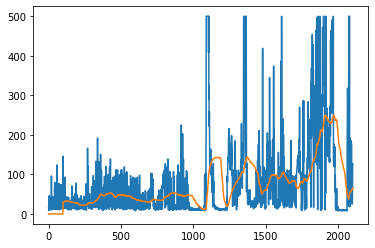

In [29]:
total_rewards = []
memory = collections.deque(maxlen=memory_size)

target.eval()

for i_episode in range(n_episodes):    
    state = env.reset()
    episode_reward = 0
    while True:           
        if np.random.random() <= p_exploration(i_episode):
            action = env.action_space.sample()
        else:
            policy.eval()
            qvalues = policy(torch.tensor(state.reshape((1,-1)), dtype=torch.float))
            action = int(qvalues.argmax().detach())
        newstate, reward, done, info = env.step(action)
        episode_reward += reward        
        memory.append((state, action, reward, newstate, done))        
        state = newstate
                
        if len(memory) >= batch_size:
            indices = np.random.choice(len(memory), size=batch_size, replace=False)
            training_step([memory[i] for i in indices], gamma=gamma)            
        
        if done:            
            break   
            
    total_rewards.append(episode_reward)    
    if (i_episode+1) % 100 == 0:
        plot_chart(total_rewards, window)
        
    running_avg = np.mean(total_rewards[-window:])
    if running_avg >= stop_at:
        print("Ending at", running_avg)
        break
                
    if i_episode % update_period == 0:
        target.load_state_dict(policy.state_dict())

## Using the agent

Finally the agent is trained! The following cell will use the agent to display a full run of the environment. Observe how much longer this agent is capable of balancing the cart than the random agent from the beginning of the notebook. If you were luck the agent will go for 500 steps, at which point the environment stops, probably assuming that the agent can do this more or less indefinitely.

In [ ]:
policy.eval()
state = env.reset()
n = 0
while True:
    env.render()    
    qvalues = policy(torch.tensor(state.reshape((1,-1)), dtype=torch.float))
    action = int(qvalues.argmax().detach())    
    state, _, done, _ = env.step(action)
    n += 1
    if done:
        print(n)
        break